# Trignometric Function Prediction by RNN - Copy

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


# This shows good pic: format from classic style; color and style from seaborn
plt.style.use('classic')
plt.style.use('seaborn')


# Hyper-Parameters
TIME_STEP = 50      # mini-batch size
SKIP = 3            # skip some time-steps to prepare hidden state in mini-batch training

INPUT_SIZE = 1      # rnn input size
HIDDEN_SIZE = 8     # rnn hidden size
OUTPUT_SIZE = 1     # rnn output size

LR = 1e-2           # learning rate

## Data

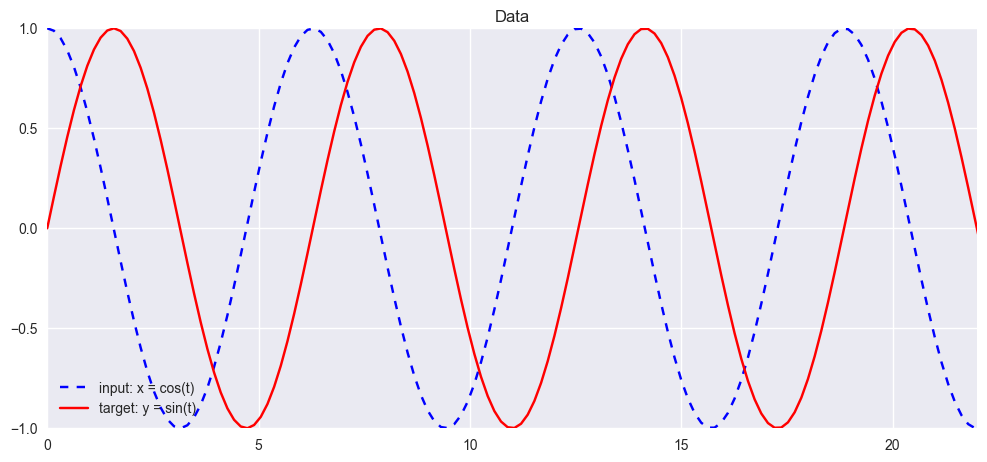

In [2]:
# Generate data: train a RNN to input cos(t) to predict sin(t)
steps = np.linspace(0, 10* np.pi, 200, dtype=np.float32)[:, np.newaxis]  # time steps
x_np = np.cos(steps)
y_np = np.sin(steps)


# Plot some data
plt.figure(1, figsize=(12, 5))
plt.plot(steps, x_np, 'b', linestyle='dashed', label='input: x = cos(t)')
plt.plot(steps, y_np, 'r', label='target: y = sin(t)')
plt.legend(loc='lower left')
plt.title('Data')
plt.xlim(0, 22)
plt.ylim(-1, 1)
plt.show()

## Model

In [3]:
class RNN(nn.Module):
    """ Add nonlinearity to the recurrent layer to see the difference """
    
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.FC1 = nn.Linear(input_size, hidden_size)
        self.RC2 = nn.Linear(hidden_size, hidden_size)
        self.FC3 = nn.Linear(hidden_size, output_size)

    def forward(self, x, last_hidden):
        
        recurrent = self.RC2(last_hidden)

        hidden = F.relu(self.FC1(x) + recurrent)
        output = self.FC3(hidden)

        return output, hidden

In [4]:
# Model
rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)

# Optimizer
optim = torch.optim.Adam(rnn.parameters(), lr=LR)

# Loss function
loss_fn = nn.MSELoss()

## Plot

In [5]:
def evaluate_and_plot(X, Y, model, plot):

    pred_lst = []
    hidden = Variable(torch.zeros(1, HIDDEN_SIZE))  # re-initialize hidden state

    for t in range(len(X)):
        x = Variable(torch.from_numpy(X[t:t+1, :]))

        predict, hidden = rnn(x, hidden)
        hidden = Variable(hidden.data)

        pred_lst.append(predict.data[0][0])

    
    if plot:
        plt.figure(1, figsize=(12, 5))

        plt.plot(steps, Y.flatten(), 'r', label='target')
        plt.plot(steps, np.array(pred_lst), 'b', label='prediction')
        plt.legend(loc='lower left')

        plt.show()

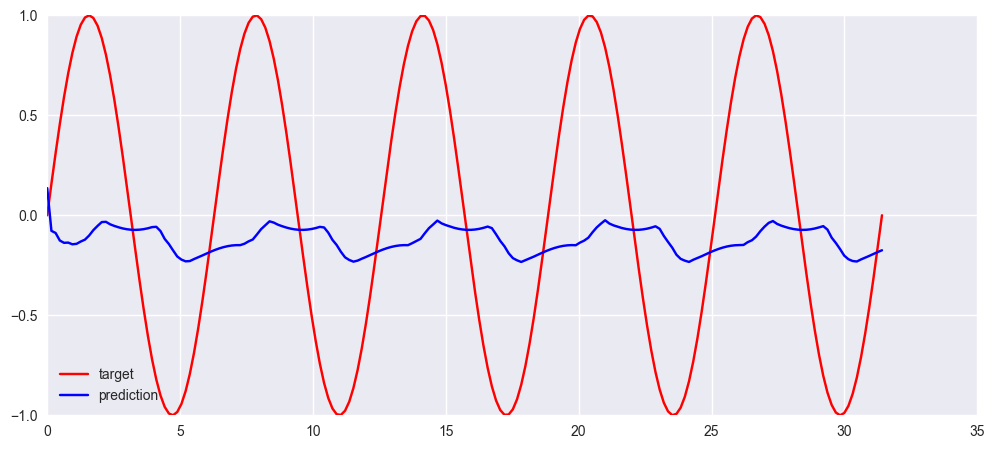

In [6]:
""" Before training, RNN ouptuts the curve like this... """

evaluate_and_plot(x_np, y_np, rnn, plot=True)

## Training

In [7]:
def train_step(X, Y, model, epochs):
    
    N = len(X)
    
    # Train for __ epochs, an epoch means that every data point is picked once in expectation   
    for epoch in range(epochs):

        for iteration in range(int(N/TIME_STEP)):

            # Pick start index in the dataset to create a mini-batch. Consider sequences of length TIME_STEP+SKIP.

            """
            *Trick* it would be problematic to always start training with empty hidden state, so we sample a longer
                    sequence (TIME_STEP + SKIP); perform a complete forward pass but only backprop for TIME_STEP many
                    steps.
            """
            start = np.random.randint(N)
            prestart = max(start - SKIP, 0)
            end = min(start + TIME_STEP, 200)


            # Extract mini-batch
            trainX = X[prestart:end, :]
            trainY = Y[prestart:end, :]


            # Initialize hidden state for each mini-batch of training
            hidden = Variable(torch.randn(1, HIDDEN_SIZE))* .2


            # Forward pass and loss compute
            Loss = 0
            for t in range(len(trainX)):  # note it may be less that TIME_STEP+SKIP many time-steps

                x = Variable(torch.from_numpy(x_np[t:t+1, :]))
                y = Variable(torch.from_numpy(y_np[t:t+1, :]))

                predict, hidden = rnn(x, hidden)

                # Skip the first SKIP many time-steps for the reason stated above.
                if t < start - prestart: continue


                loss = loss_fn(predict, y)
                Loss += loss


            # Backward pass and param update
            optim.zero_grad()
            Loss.backward()
            optim.step()
    
    return model

In [8]:
""" Training """

rnn = train_step(x_np, y_np, model=rnn, epochs=30)

## Evaluate

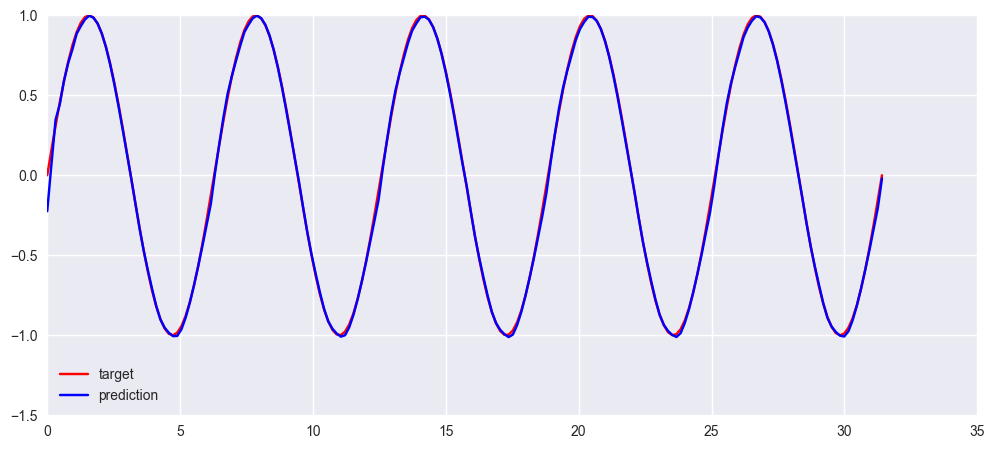

In [10]:
""" Training Evaluation """        

evaluate_and_plot(x_np, y_np, rnn, plot=True)

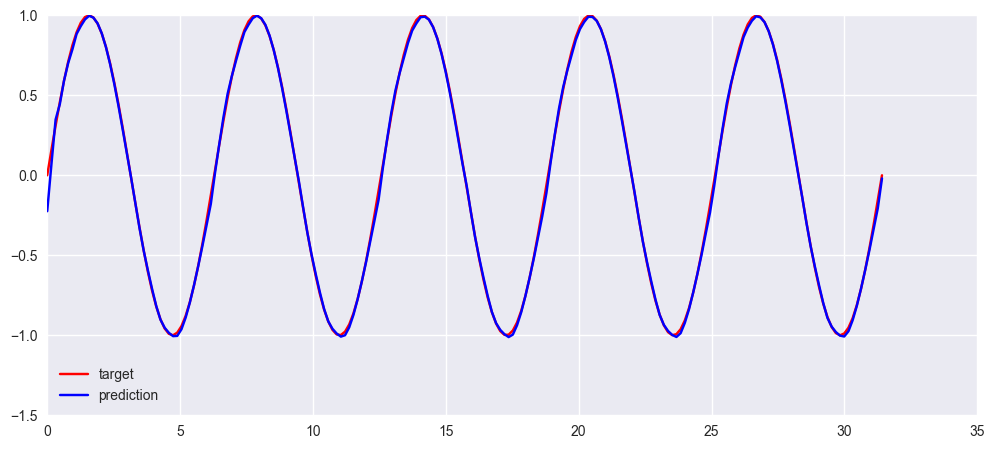

In [11]:
""" Test Evaluation """

# Generate new data to test the model on unseen data
steps2 = np.linspace(10* np.pi, 20* np.pi, 200, dtype=np.float32)[:, np.newaxis]
x_np2 = np.cos(steps2)
y_np2 = np.sin(steps2)


#
evaluate_and_plot(x_np2, y_np2, rnn, plot=True)